In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_fontja

In [2]:
df_trend = pd.read_csv("../data/trend/trend_data.csv")

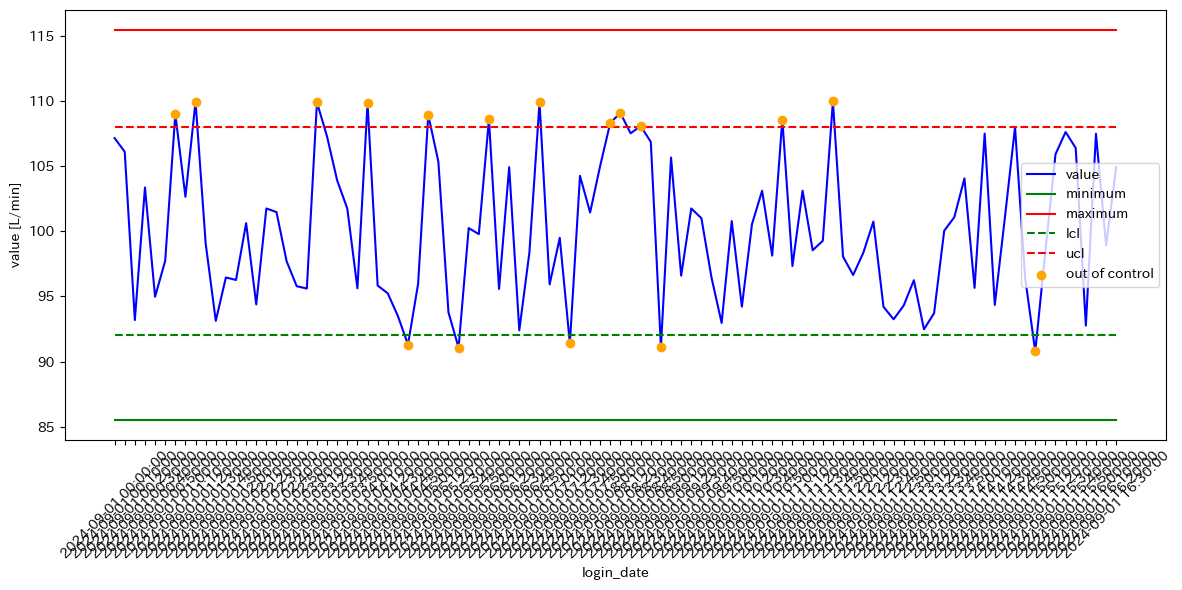

In [4]:
product = "製品0"
parameter = "FlowRate_L_min"

_df = df_trend.loc[(df_trend["product"]==product) & (df_trend["parameter"]==parameter)]

fig, ax = plt.subplots(figsize=(12, 6))

# プロット
ax.plot(_df["login_date"], _df["value"], label="value", color="blue")
ax.plot(_df["login_date"], _df["minimum"], label="minimum", color="green", linestyle="-")
ax.plot(_df["login_date"], _df["maximum"], label="maximum", color="red", linestyle="-")
ax.plot(_df["login_date"], _df["lcl"], label="lcl", color="green", linestyle="--")
ax.plot(_df["login_date"], _df["ucl"], label="ucl", color="red", linestyle="--")

# 管理外点を強調
out_of_control = _df[~_df["in_control"]]
ax.scatter(out_of_control["login_date"], out_of_control["value"], color="orange", label="out of control", zorder=10)

ax.set_xlabel("login_date")
ax.set_ylabel(f"value [{_df['unit'].iloc[0]}]")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 類似点の検出

In [5]:
from utils import find_similar_subsequences

In [7]:
# 結合した時系列
s = df_trend.loc[df_trend["parameter"] == "FlowRate_L_min", "value"].reset_index(drop=True)

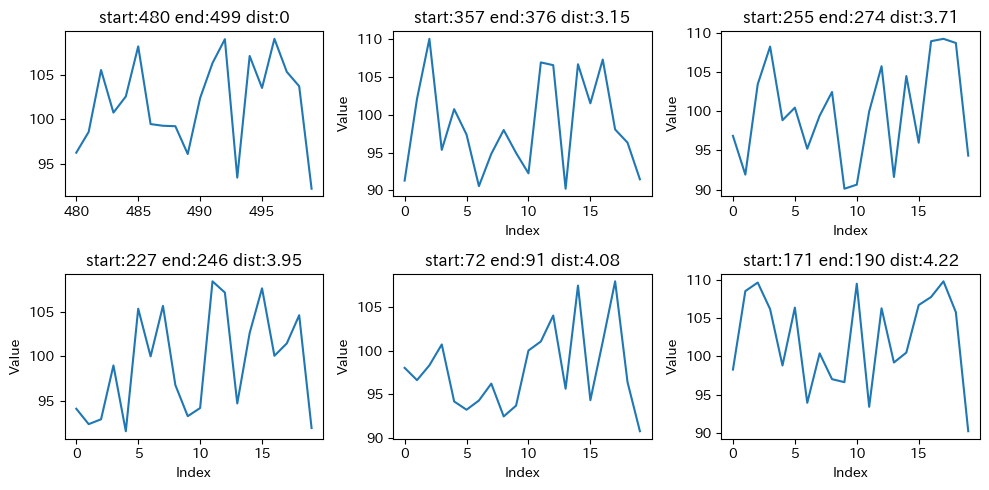

In [9]:
# 類似検索（ユークリッド距離）
query_slice = (480, 499)
results = find_similar_subsequences(s, query_slice=query_slice, method="euclid", znorm=True, top_k=5, stride=1)

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
axes = axes.flatten()

# 元データ
axes[0].plot(s.loc[query_slice[0]:query_slice[1]])
axes[0].set_title(f"start:{query_slice[0]} end:{query_slice[1]} dist:0")

# 検索結果
for i, row in results.iterrows():
    axes[i+1].plot(row['subsequence'])
    axes[i+1].set_title(f"start:{row['start_index']} end:{row['end_index']} dist:{row['distance']:.2f}")
    axes[i+1].set_xlabel("Index")
    axes[i+1].set_ylabel("Value")

plt.tight_layout()
plt.show()

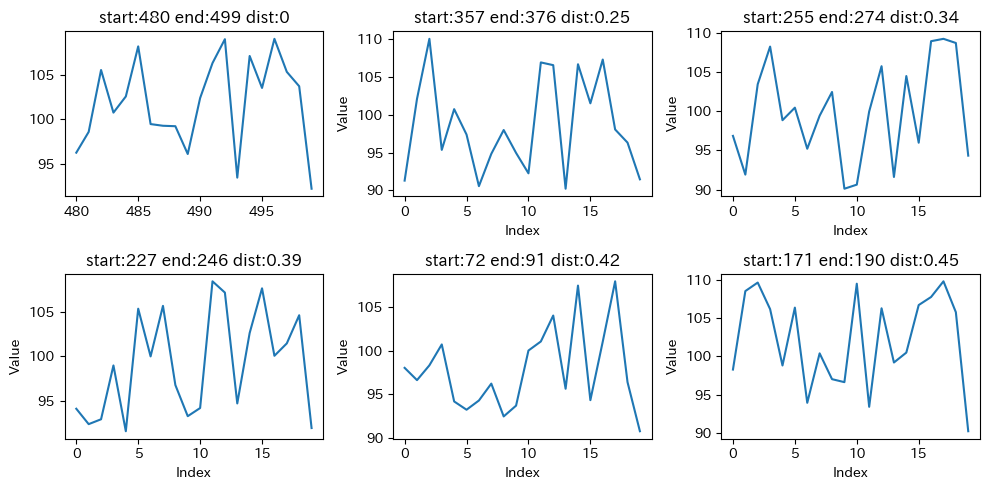

In [10]:
# 類似検索（コサイン類似度）
query_slice = (480, 499)
results = find_similar_subsequences(s, query_slice=query_slice, method="cosine", znorm=True, top_k=5, stride=1)

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
axes = axes.flatten()

# 元データ
axes[0].plot(s.loc[query_slice[0]:query_slice[1]])
axes[0].set_title(f"start:{query_slice[0]} end:{query_slice[1]} dist:0")

# 検索結果
for i, row in results.iterrows():
    axes[i+1].plot(row['subsequence'])
    axes[i+1].set_title(f"start:{row['start_index']} end:{row['end_index']} dist:{row['distance']:.2f}")
    axes[i+1].set_xlabel("Index")
    axes[i+1].set_ylabel("Value")

plt.tight_layout()
plt.show()

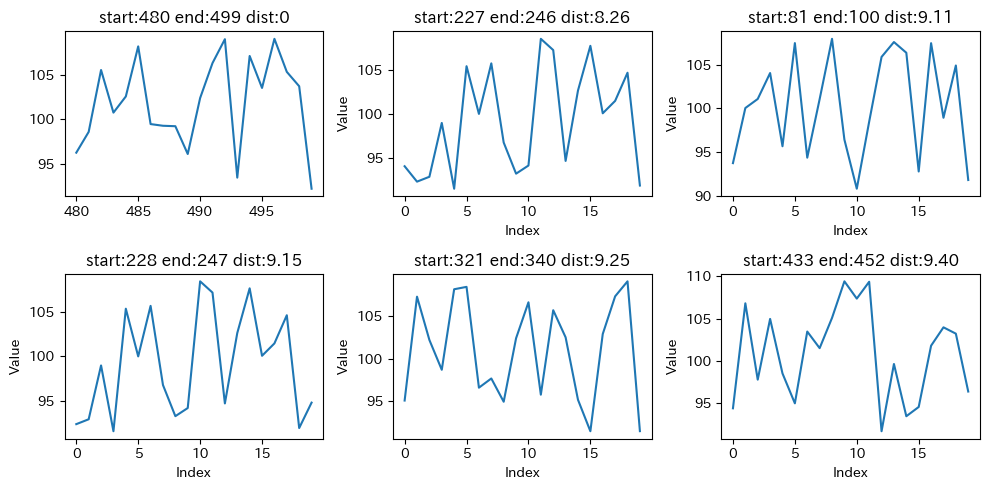

In [11]:
# 類似検索（DTW）（※時間方向のズレ・伸縮に強い）
query_slice = (480, 499)
results = find_similar_subsequences(s, query_slice=query_slice, method="dtw", znorm=True, top_k=5, stride=1)

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
axes = axes.flatten()

# 元データ
axes[0].plot(s.loc[query_slice[0]:query_slice[1]])
axes[0].set_title(f"start:{query_slice[0]} end:{query_slice[1]} dist:0")

# 検索結果
for i, row in results.iterrows():
    axes[i+1].plot(row['subsequence'])
    axes[i+1].set_title(f"start:{row['start_index']} end:{row['end_index']} dist:{row['distance']:.2f}")
    axes[i+1].set_xlabel("Index")
    axes[i+1].set_ylabel("Value")

plt.tight_layout()
plt.show()